# 1. Imports

In [1]:
import pandas as pd
import json
import os
import copy
import time
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# 2. Loading data

## 2.1 Identify id:s for Liverpool games

In [37]:
# path = 'C:\\Users\\johnl\\Documents\\GitHub\\opendata\\data\\matches.json'

# with open(path) as f:
#     data = json.load(f)

# # print(json.dumps(data, indent=4, sort_keys=True))

# # Manually found that the Liverpool games has id's 4039 and 2440

path = 'C:\\Users\\jakes\\Desktop\\Data Science\\Mathematical Modelling in Football\\Group Project\\Data\\SkillCorner\\opendata-master\\data\\matches'

id1 = '\\4039'
id2 = '\\2440'

## 2.2 Create player dict

In [41]:
def create_player_dicts(path, match_id):

    with open(path + '\\' + match_id + '\\match_data.json') as f:
        data = json.load(f)

    name_dict = {}
    for player in data['players']:
        obj_id = player['trackable_object']
        first_name = player['first_name']
        last_name = player['last_name']
        name_dict[obj_id] = first_name + ' ' + last_name

    lfc_dict = {}
    lfc_list = []
    if data['id'] == 4039:
        lfc_id = data['away_team']['id']
        for player in data['players']:
            if player['team_id'] == lfc_id:
                obj_id = player['trackable_object']
                first_name = player['first_name']
                last_name = player['last_name']
                lfc_dict[obj_id] = first_name + ' ' + last_name
                lfc_list.append(obj_id)

    return name_dict, lfc_dict, lfc_list

In [42]:
name_dict, lfc_dict, lfc_list = create_player_dicts(path, match_id=id1)

In [40]:
# Merge this dictionary with the above
with open(path + '\\' + id1 + '\\match_data.json') as f:
        data = json.load(f)

lfc_pos_dict = {}
lfc_pos_list = []
if data['id'] == 4039:
    lfc_id = data['away_team']['id']
    for player in data['players']:
        if player['team_id'] == lfc_id:
            obj_id = player['trackable_object']
            pos = player['player_role']['acronym']
            lfc_pos_dict[obj_id] = pos
            lfc_pos_list.append(obj_id)

lfc_pos_dict

{11879: 'LW',
 25648: 'RWB',
 515: 'SUB',
 2792: 'CF',
 11589: 'LM',
 14219: 'SUB',
 4683: 'SUB',
 11855: 'SUB',
 274: 'SUB',
 9143: 'CF',
 9449: 'LW',
 7745: 'RW',
 5318: 'RM',
 3267: 'CM',
 3847: 'LM',
 851: 'LWB',
 10748: 'LCB',
 11537: 'RCB',
 11847: 'RWB',
 11565: 'GK'}

## 2.3 Load and explore tracking data 

In [5]:
def load_tracking_data(path, match_id, name_dict):
    
    with open(path + match_id + '\\structured_data.json') as f:
        data = json.load(f)
    
    df = pd.DataFrame( columns = [i for i in name_dict.keys()] )
    
    new_frame = {}
    for i in df.columns:
        new_frame[i] = None

    li =  []
    for frame in data:
        frame_nr = frame['frame']
        curr_frame = copy.deepcopy(new_frame)
        for obj in frame['data']:
            x = obj['x']
            y = obj['y']
            try:
                obj_id = obj['trackable_object']
                curr_frame[obj_id] = (x, y)
            except:
                None
        row = pd.Series(curr_frame, name = frame_nr)
        li.append(curr_frame)

    df = pd.DataFrame(li)
    
    return df

In [6]:
df = load_tracking_data(path, id1, name_dict)

In [7]:
def create_lfc_dict(df, lfc_list):
    lfc_df = df[lfc_list]

    for col in lfc_df.columns:
        player_df = lfc_df[col]
        p = len([i for i in player_df if i!= None])/len(player_df)
        #if p == 0.0:
        #    lfc_df = lfc_df.drop(columns=col)

    lfc_list = [i for i in lfc_df.columns]
    
    return lfc_df, lfc_list

In [8]:
lfc_df, lfc_list = create_lfc_dict(df, lfc_list)

In [9]:
# col_list = []
# p_list = []
# for col in df.columns:
#     player_df = df[col]
#     p = len([i for i in player_df if i!= None])/len(player_df)
#     # print(col, p)
#     col_list.append(str(col))
#     p_list.append(p)

# plt.bar(x=col_list, height=p_list)

<BarContainer object of 20 artists>

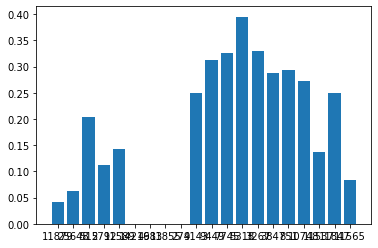

In [10]:
col_list = []
p_list = []
for col in lfc_df.columns:
    player_df = lfc_df[col]
    p = len([i for i in player_df if i!= None])/len(player_df)
    # print(col, p)
    col_list.append(str(col))
    p_list.append(p)

plt.bar(x=col_list, height=p_list)

Obviously, for all players, more than half of the game is not covered by the broadcast data. This is a clear limitation. However, the most important parts of the games (i.e. those when they are close to the ball) is likely to be the ones visible in the broadcast and this may thus not be a huge problem. It is not likely that players far from the ball will run as quick as the ones close to the ball.

**To investigate:**
* Ways to interpolate player positions

# 3. Velocity

## 3.1 Compute velocities 

In [11]:
'''
Manually checked the time intervals. dt = 0.1 seconds
'''


# with open('C:\\Users\\johnl\\Documents\\GitHub\\opendata\\data\\matches\\4039\\structured_data.json') as f:
#         data = json.load(f)

# [frame['time'] for frame in data]

dt = 0.1

In [12]:
# lfc_df_numeric = lfc_df.fillna(value=np.nan)

lfc_cords = pd.DataFrame()

for col in lfc_df.columns:
    x_list = []
    y_list = []
    for i in lfc_df[col]:
        if i == None:
            x_list.append(np.nan)
            y_list.append(np.nan)
        else:
            x_list.append(i[0])
            y_list.append(i[1])
    x_col = str(col)+'_x'
    y_col = str(col)+'_y'
    lfc_cords[x_col] = x_list
    lfc_cords[y_col] = y_list

lfc_cords

,11879_x,11879_y,25648_x,25648_y,515_x,515_y,2792_x,2792_y,11589_x,11589_y,...,851_x,851_y,10748_x,10748_y,11537_x,11537_y,11847_x,11847_y,11565_x,11565_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68311,-45.892240,-3.379340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-50.214575,3.732083,-47.965296,-10.154093,NaN,NaN,NaN,NaN,-51.142657,-5.108592
68312,-46.009826,-3.273267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-50.551537,3.692949,-47.969735,-10.139654,NaN,NaN,NaN,NaN,-51.135727,-5.156821
68313,-46.212437,-3.021497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-50.862337,3.676952,-47.977826,-10.132423,NaN,NaN,NaN,NaN,-51.069791,-5.275733
68314,-46.442017,-2.710579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-51.127911,3.638456,-47.986345,-10.127046,NaN,NaN,NaN,NaN,-50.972910,-5.436047


In [17]:
lfc_cords_diff = lfc_cords.diff(periods=1, axis=0)
lfc_cords_diff

,11879_x,11879_y,25648_x,25648_y,515_x,515_y,2792_x,2792_y,11589_x,11589_y,...,851_x,851_y,10748_x,10748_y,11537_x,11537_y,11847_x,11847_y,11565_x,11565_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68311,-0.182076,0.171674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.426859,0.064200,-0.013296,0.004529,NaN,NaN,NaN,NaN,0.039281,-0.090923
68312,-0.117586,0.106073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.336962,-0.039134,-0.004439,0.014439,NaN,NaN,NaN,NaN,0.006930,-0.048229
68313,-0.202612,0.251771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.310800,-0.015996,-0.008091,0.007231,NaN,NaN,NaN,NaN,0.065936,-0.118912
68314,-0.229579,0.310918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.265574,-0.038497,-0.008519,0.005377,NaN,NaN,NaN,NaN,0.096881,-0.160314


In [13]:
vel_lfc_df = pd.DataFrame()

for i in lfc_list:
    dx_col = str(i)+'_x'
    dy_col = str(i)+'_y'
    dx = lfc_cords_diff[dx_col]
    dy = lfc_cords_diff[dy_col]
    v = np.sqrt(dx**2 + dy**2)/dt
    
    for j in range(len(v)):
        if v[j] > 12.5: # Usain Bolt's top speed
            v[j] = np.nan
    
    vel_lfc_df[i] = v

vel_lfc_df

NameError: name 'lfc_cords_diff' is not defined

<BarContainer object of 20 artists>

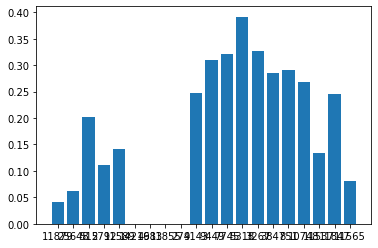

In [19]:
# new check after dropping outlier velocities

p_list2 = [i for i in vel_lfc_df.count()/len(vel_lfc_df)]
col_list2 = [str(i) for i in vel_lfc_df.columns]

plt.bar(x=col_list2, height=p_list2)

In [14]:
# printing how much data (as proportion of total frames in the game) is dropped due to the removing of outliers
assert len(p_list) == len(p_list2)

for i in range(len(p_list)):
    print(p_list[i]-p_list2[i])

NameError: name 'p_list2' is not defined

Relatively little data seem to be dropped by removing the outliers which is a sign that we do not lose much valuable information by doing it. It seems reasonable to assume that the benfits of getting rid of obvious outlier speeds outweighs the fact that we get even less data. Hopefully, we can solve some of these gaps by using smoothing later on.

## 3.2 Smoothing of velocities 

In [25]:
smoothed_vel_lfc_df = pd.DataFrame()

n = len(vel_lfc_df)
w = 3

t0 = time.time()
for player in lfc_list:
    v_smoothed = [] 
    for j in range(n):
        try:
            v_smoothed.append( np.mean(vel_lfc_df[player][j-w+1:j+1]) )
        except:
            v_smoothed[j].append( vel_lfc_df[player][j] )
    smoothed_vel_lfc_df[player] = v_smoothed
print(time.time()-t0)

vel_lfc_df

0.014959335327148438


""


In [26]:
smoothed_vel_lfc_df

,11879,25648,515,2792,11589,14219,4683,11855,274,9143,9449,7745,5318,3267,3847,851,10748,11537,11847,11565


## 3.2.1 Smoothing data

In [19]:
import scipy.signal as signal
calc_df = lfc_cords_diff # new data frame not to intefere with the rest

# Compute distance, raw velocity and velocity with various smoothing filters
for i in lfc_dict:
    calc_df[str(i)+'_dist'] = np.sqrt(calc_df[str(i)+'_x']**2 + calc_df[str(i)+'_y']**2)
    calc_df[str(i)+'_speed'] = calc_df[str(i)+'_dist']/0.1
    calc_df[str(i)+'_speed'] = calc_df[str(i)+'_speed'].apply(lambda x: np.nan if x > 12 else x) # Usain Bolt filter
    calc_df[str(i)+'_acc'] = calc_df[str(i)+'_speed'].diff()/0.1
    calc_df[str(i)+'_SG3_speed'] = signal.savgol_filter(calc_df[str(i)+'_speed'], 3, 1, mode='nearest')    
    calc_df[str(i)+'_SG5_speed'] = signal.savgol_filter(calc_df[str(i)+'_speed'], 5, 1, mode='nearest')
    #calc_df[str(i)+'_SG7_speed'] = signal.savgol_filter(calc_df[str(i)+'_speed'], 7, 1, mode='nearest')
    #calc_df[str(i)+'_SG9_speed'] = signal.savgol_filter(calc_df[str(i)+'_speed'], 9, 1, mode='nearest')
    calc_df[str(i)+'_SG5_acc'] = calc_df[str(i)+'_SG5_speed'].diff()/0.1
    calc_df[str(i)+'_SG3_SG5_acc'] = signal.savgol_filter(calc_df[str(i)+'_SG5_acc'], 3, 1, mode='nearest')

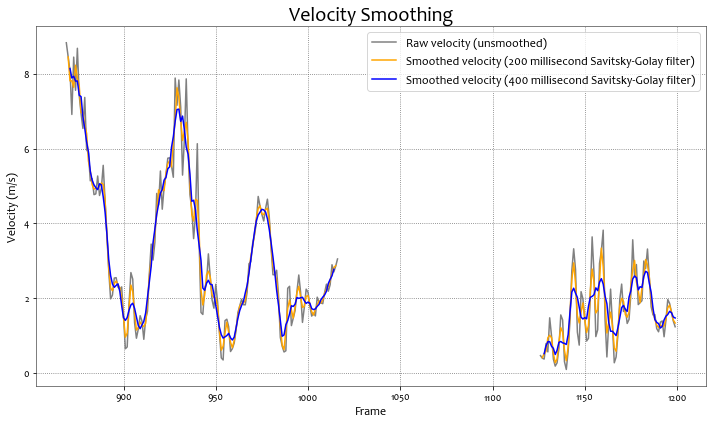

In [20]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.family"] = "Candara"

# Velocity plot
plt.plot(calc_df[800:1200]['5318_speed'], label='Raw velocity (unsmoothed)', color='gray')
plt.plot(calc_df[800:1200]['5318_SG3_speed'], label='Smoothed velocity (200 millisecond Savitsky-Golay filter)', color='orange')
plt.plot(calc_df[800:1200]['5318_SG5_speed'], label='Smoothed velocity (400 millisecond Savitsky-Golay filter)', color='blue')
#plt.plot(calc_df[800:1200]['5318_SG7_speed'], label='Smoothed velocity (600 millisecond Savitsky-Golay filter)', color='blue')
#plt.plot(calc_df[800:1200]['5318_SG9_speed'], label='Smoothed velocity (800 millisecond Savitsky-Golay filter)', color='blue')
plt.legend(fontsize=12)
plt.grid(True, color = 'dimgray', linestyle='dotted')
plt.title("Velocity Smoothing", fontsize=20)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Velocity (m/s)', fontsize=12)
plt.tight_layout()

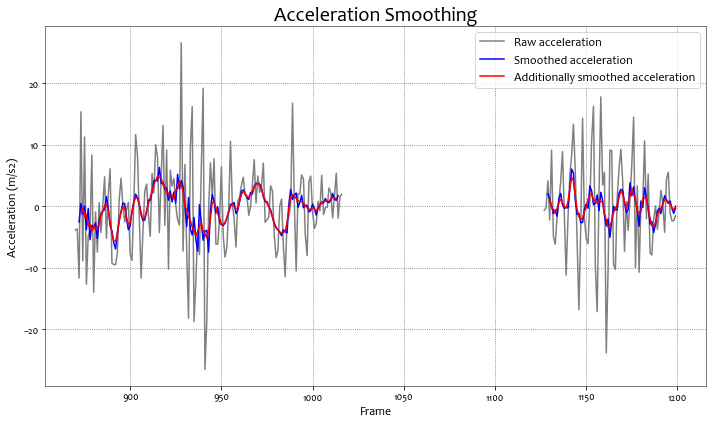

In [21]:
# Acceleration plot
plt.plot(calc_df[800:1200]['5318_acc'], label='Raw acceleration', color='gray')
plt.plot(calc_df[800:1200]['5318_SG5_acc'], label='Smoothed acceleration', color='blue')
plt.plot(calc_df[800:1200]['5318_SG3_SG5_acc'], label='Additionally smoothed acceleration', color='red')
plt.legend(fontsize=12)
plt.grid(True, color = 'dimgray', linestyle='dotted')
plt.title("Acceleration Smoothing", fontsize=20)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Acceleration (m/s2)', fontsize=12)
plt.tight_layout()

In [ ]:
# Savitsky-Golay 5 window filter for velocity 
# Additional filter improvement but not strictly necessary

## 3.3 Decompose into speed zones

In [28]:
def dist_per_speed_zone(vel_df, player_id, bins):
    x = vel_df[player_id]
    w = len(x)*[0.1]
    
    n = plt.hist(x, bins = bins, weights = w)
    
    return n

(array([0., 0., 0., 0., 0.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5]),
 <a list of 5 Patch objects>)

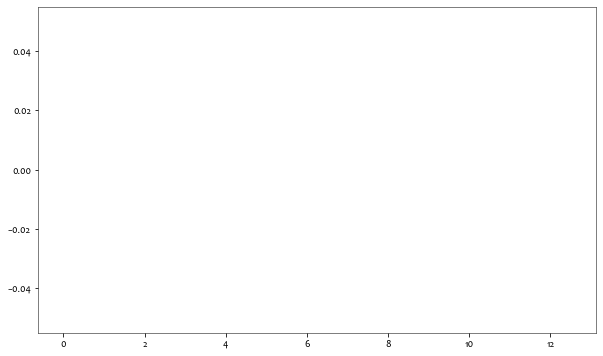

In [29]:
player_id = 5318
bins = [0,2.5,5,7.5,10,12.5]

dist_per_speed_zone(smoothed_vel_lfc_df, player_id, bins)

In [62]:
def distance_in_speed_zone(vel_df, player_id, min_speed, max_speed):
    return sum( vel_df[player_id].between(min_speed, max_speed) ) /10

In [65]:
player_id = 5318
min_speed = 2
max_speed = 8

distance_in_speed_zone(smoothed_vel_lfc_df, player_id, min_speed, max_speed)

1534.3

## 3.4 Summary Statistics

In [43]:
# Used for summary statistics
dist_df = calc_df.loc[:, calc_df.columns.str.contains('dist')]
speed_df = calc_df.loc[:, calc_df.columns.str.contains('SG5_speed')]
acc_df = calc_df.loc[:, calc_df.columns.str.contains('SG3_SG5_acc')]

In [44]:
# Change depending on game data loaded (maybe there is a better way to do this?)
ht_start_frame = 29070
ht_end_frame = 38948
ht_interval = ht_end_frame - ht_start_frame

# Compute minutes played, removing half time duration and benched mins
def mins_on_pitch(data):
    if data.start_index > ht_start_frame + 1000 and data.end_index > len(dist_df) - 100:
        return (len(dist_df) - data.start_index)*0.1/60 # sub on mins
    else:
        return (data.end_index - ht_interval)*0.1/60

In [45]:
summary_stats = pd.DataFrame.from_dict(lfc_dict, orient ='index')
summary_stats = summary_stats.rename(columns = {0: 'name'})
summary_stats['start_index'] = np.array(dist_df.apply(lambda col: col.first_valid_index()))
summary_stats['end_index'] = np.array(dist_df.apply(lambda col: col.last_valid_index()))     
summary_stats['mins'] = summary_stats.apply(mins_on_pitch, axis = 1)
#summary_stats['startXI'] = summary_stats['start_index'].apply(lambda x: 1 if x < ht_start_frame else 0)
summary_stats['mins_visible'] = (len(dist_df) - np.array(dist_df.isna().sum()))*0.1/60

In [47]:
# Minutes breakdown and max speed/acceleration
summary_stats['mins'] = summary_stats.apply(mins_on_pitch, axis = 1)
#summary_stats['startXI'] = summary_stats['start_index'].apply(lambda x: 1 if x < ht_start_frame else 0)
summary_stats['mins_visible'] = (len(dist_df) - np.array(dist_df.isna().sum()))*0.1/60
summary_stats['mins_missing'] = summary_stats.mins - summary_stats.mins_visible
summary_stats['obs_dist'] = np.array(speed_df.sum())/10/1000
summary_stats['max_speed'] = np.array(speed_df.max())
summary_stats['max_speed_99pc'] = np.array(speed_df.quantile(0.99)) # Results seem better, except Salah being lower than expected
summary_stats['max_acc'] = np.array(acc_df.max())
summary_stats['max_acc_99pc'] = np.array(acc_df.quantile(0.99)) # Unsure about these values... check with other games

In [48]:
# Speed threshold distances and ratios
summary_stats['walk_dist'] = np.array(speed_df[(speed_df > 0) & (speed_df <= 2)].sum()/10/1000)
summary_stats['jog_dist'] = np.array(speed_df[(speed_df > 2) & (speed_df <= 4)].sum()/10/1000)
summary_stats['run_dist'] = np.array(speed_df[(speed_df > 4) & (speed_df <= 7)].sum()/10/1000)
summary_stats['sprint_dist'] = np.array(speed_df[speed_df >= 7].sum()/10/1000)
summary_stats['walk_ratio'] = summary_stats.walk_dist/(summary_stats.run_dist+summary_stats.jog_dist+summary_stats.walk_dist)
summary_stats['jog_ratio'] = summary_stats.jog_dist/(summary_stats.run_dist+summary_stats.jog_dist+summary_stats.walk_dist)
summary_stats['run_ratio'] = summary_stats.run_dist/(summary_stats.run_dist+summary_stats.jog_dist+summary_stats.walk_dist)
# sprint_ratio ignored since won't be added for extrapolated values

In [49]:
summary_stats

,name,start_index,end_index,mins,mins_visible,mins_missing,obs_dist,max_speed,max_speed_99pc,max_acc,max_acc_99pc,walk_dist,jog_dist,run_dist,sprint_dist,walk_ratio,jog_ratio,run_ratio
11879,Minamino Takumi,62583.0,68315.0,9.555000,4.625000,4.930000,0.753845,7.983417,7.221394,7.795393,5.107137,0.133177,0.266321,0.312598,0.041750,0.187022,0.373995,0.438983
25648,Neco Williams,57262.0,68287.0,18.423333,7.003333,11.420000,1.212494,9.332290,7.428780,11.966307,4.954220,0.182338,0.437093,0.516595,0.076469,0.160505,0.384756,0.454739
515,Alex Oxlade-Chamberlain,38839.0,68255.0,49.128333,22.925000,26.203333,3.431088,9.324535,7.195826,14.056283,4.572723,0.675993,1.536455,1.091544,0.127097,0.204599,0.465030,0.330371
2792,Divock Origi,49044.0,68236.0,32.120000,12.625000,19.495000,1.942492,10.127846,7.957920,14.045320,5.741114,0.387126,0.671701,0.735950,0.147716,0.215696,0.374253,0.410051
11589,Naby Keita,48855.0,68253.0,32.435000,16.036667,16.398333,2.505146,8.166987,6.769735,14.283697,4.933940,0.427178,1.154142,0.880178,0.043647,0.173544,0.468878,0.357578
14219,Harvey Elliott,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4683,James Milner,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
11855,Curtis Jones,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
274,Adrian,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
9143,Roberto Firmino,450.0,48256.0,63.963333,28.255000,35.708333,4.735335,10.104305,7.715742,13.011944,4.744404,0.627202,1.961003,1.869230,0.277900,0.140709,0.439940,0.419351


In [50]:
# Decomposing unobserved distance

walk_speed = 2 # Use value between 0-2
jog_speed = 3 # Use value between 2-4
run_speed = 5 # Use value between 4-7
sprint_speed = 7 # Use value greater than 7

walk_weight = 0.66 # 66% missing data assumed walking speed, 33% extrapolated using observed running/jogging ratio

summary_stats['walk_dist_adj'] = walk_weight*(walk_speed*summary_stats.mins_missing)*60/1000
summary_stats['jog_dist_adj'] = (1-walk_weight)*(summary_stats.jog_ratio)*(summary_stats.mins_missing*jog_speed)*60/1000
summary_stats['run_dist_adj'] = (1-walk_weight)*(summary_stats.run_ratio)*(summary_stats.mins_missing*run_speed)*60/1000
# Assumed no sprinting off ball

summary_stats['total_dist_xtrp'] = summary_stats.walk_dist_adj + summary_stats.jog_dist_adj + summary_stats.run_dist_adj + summary_stats.sprint_dist

summary_stats['walk_dist_total'] = summary_stats.walk_dist + summary_stats.walk_dist_adj
summary_stats['jog_dist_total'] = summary_stats.jog_dist + summary_stats.jog_dist_adj
summary_stats['run_dist_total'] = summary_stats.run_dist + summary_stats.run_dist_adj
summary_stats['sprint_dist_total'] = summary_stats.sprint_dist

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Minutes'),
 Text(0.5, 1.0, 'Data availability: Observed (green) / Unobserved (grey)')]

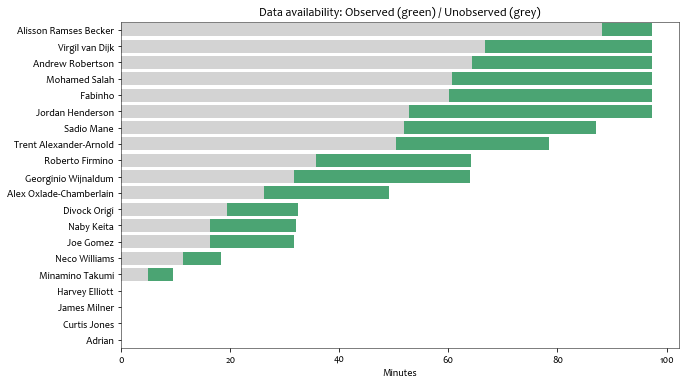

In [53]:
### Data availability
ax_top = sns.barplot(y = 'name',
                     x = 'mins',
                     data = summary_stats,
                     order = summary_stats.sort_values('mins', ascending = False).name, 
                     color = 'mediumseagreen')
ax_bottom = sns.barplot(y = 'name',
                        x = 'mins_missing',
                        data = summary_stats,
                        order = summary_stats.sort_values('mins_missing', ascending = False).name, 
                        color = 'lightgrey')

ax_top.set(xlabel='Minutes', ylabel='', title = 'Data availability: Observed (green) / Unobserved (grey)')
# Lots of data missing, how best to deal with this?
###


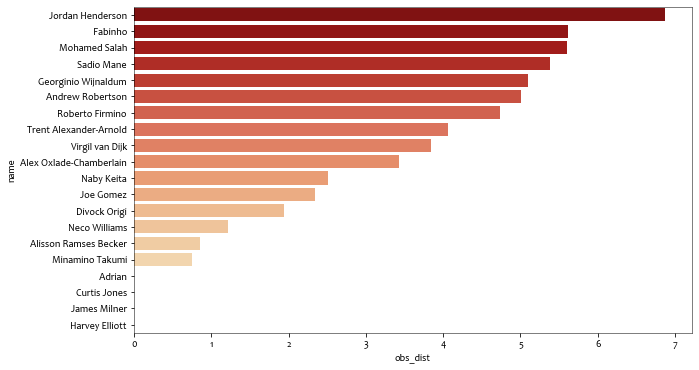

In [56]:
### Observed distance covered where players are in camera shot
sns.barplot(data = summary_stats,
            x = 'obs_dist',
            y = 'name',
            palette = 'OrRd_r',
            order = summary_stats.sort_values('obs_dist', ascending = False).name)
# Typically players can run between 9-12km a game
# This is often dependent on position - we ought to model these individually
# Analyse position profiles with data from other games
# For instance CBs unlikely to be running if out of shot, full backs more likely since they bomb forward for attacks, etc.
###

In [55]:
lfc_pos_dict # Use to fill missing data with position profiles

{11879: 'LW',
 25648: 'RWB',
 515: 'SUB',
 2792: 'CF',
 11589: 'LM',
 14219: 'SUB',
 4683: 'SUB',
 11855: 'SUB',
 274: 'SUB',
 9143: 'CF',
 9449: 'LW',
 7745: 'RW',
 5318: 'RM',
 3267: 'CM',
 3847: 'LM',
 851: 'LWB',
 10748: 'LCB',
 11537: 'RCB',
 11847: 'RWB',
 11565: 'GK'}

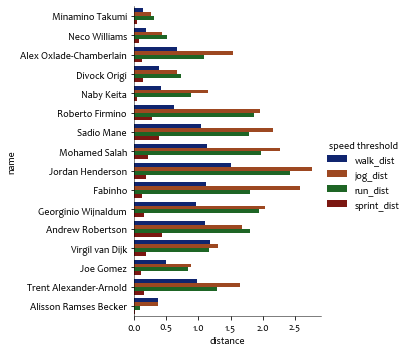

In [58]:
### Observed absolute speed threshold (doesn't include out of camera shot movements)
cols = ['name', 'walk_dist', 'jog_dist', 'run_dist', 'sprint_dist']
speed_thres = summary_stats.loc[:,cols]
speed_thres = speed_thres[(speed_thres != 0)]
speed_thres = speed_thres.dropna()
speed_thres = pd.melt(speed_thres, id_vars="name", var_name="speed threshold", value_name="distance")
sns.catplot(y = 'name',
               x = 'distance',
               hue = 'speed threshold',
               data = speed_thres,
               kind = 'bar',
               palette = 'dark')
# See https://www.youtube.com/watch?v=teCgjQ2ZKNo 8 mins in for what we should roughly be aiming for, although this doesn't give positions
# Walking underestimated so we can assume a large percentage of unrecorded data is walking speed
###

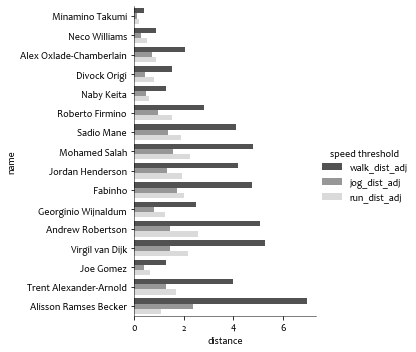

In [59]:
# Estimated values for missing data only (sprint assumed zero)
cols = ['name', 'walk_dist_adj', 'jog_dist_adj', 'run_dist_adj']
adj_speed_thres = summary_stats.loc[:,cols]
adj_speed_thres = adj_speed_thres[(adj_speed_thres != 0)]
adj_speed_thres = adj_speed_thres.dropna()
adj_speed_thres = pd.melt(adj_speed_thres, id_vars="name", var_name="speed threshold", value_name="distance")
sns.catplot(y = 'name',
               x = 'distance',
               hue = 'speed threshold',
               data = adj_speed_thres,
               kind = 'bar',
               palette = 'Greys_r')
# Alisson has around 80% missing data so is assumed to walk 7km out of range
# This is a good extreme example of why assuming the same for all players out of shot doesn't really work

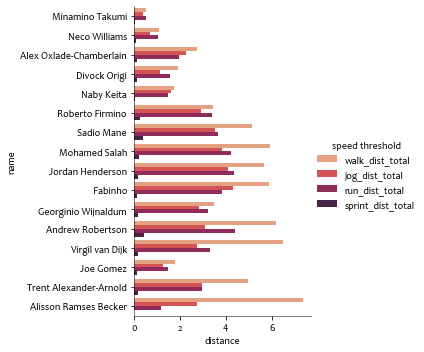

In [60]:
# Combined observed and estimated values
cols = ['name', 'walk_dist_total', 'jog_dist_total', 'run_dist_total', 'sprint_dist_total']
speed_thres = summary_stats.loc[:,cols]
speed_thres = speed_thres[(speed_thres != 0)]
speed_thres = speed_thres.dropna()
speed_thres = pd.melt(speed_thres, id_vars="name", var_name="speed threshold", value_name="distance")
sns.catplot(y = 'name',
               x = 'distance',
               hue = 'speed threshold',
               data = speed_thres,
               kind = 'bar',
               palette = 'rocket_r')
# We need to tweak the model so that we have a realistic result here
# Estimate missing walk/jog/run for each position, as using the same values for all players doesn't seem to give good results

###

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Velocity (m/s)'),
 Text(0.5, 1.0, 'Max velocity 99% quantile')]

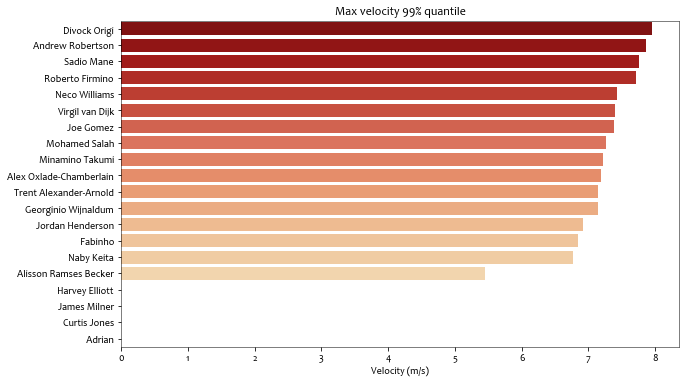

In [61]:
### Max speed visualization
ax = sns.barplot(y = 'name',
                        x = 'max_speed_99pc',
                        data = summary_stats,
                        order = summary_stats.sort_values('max_speed_99pc', ascending = False).name, 
                        palette = 'OrRd_r')

ax.set(xlabel='Velocity (m/s)', ylabel='', title = 'Max velocity 99% quantile')
###

# 4. Acceleration

## 4.1 Compute acceleration

In [51]:
# Acceleration/Decelerations

accelerations = acc_df[acc_df >= 2]
accelerations = accelerations.notnull()
b = accelerations.cumsum()
accelerations = b.sub(b.mask(accelerations).ffill().fillna(0)).astype(int)
accelerations[(accelerations != 7)] = 0
accelerations = accelerations.astype(bool).sum(axis=0)

decelerations = acc_df[acc_df <= -2]
decelerations = decelerations.notnull()
b = decelerations.cumsum()
decelerations = b.sub(b.mask(decelerations).ffill().fillna(0)).astype(int)
decelerations[(decelerations != 7)] = 0
decelerations = decelerations.astype(bool).sum(axis=0)

summary_stats['acc_count'] = np.array(accelerations)
summary_stats['dec_count'] = np.array(decelerations)
summary_stats['acc_dec_ratio'] = summary_stats.acc_count/summary_stats.dec_count

Smooothing of acceleration values shall not be needed since we smoothed the velocities and computed acceleration from this. This means that we should have removed most of the noise in the data already.

## 4.2 Decompose into acceleration/deceleration zones 

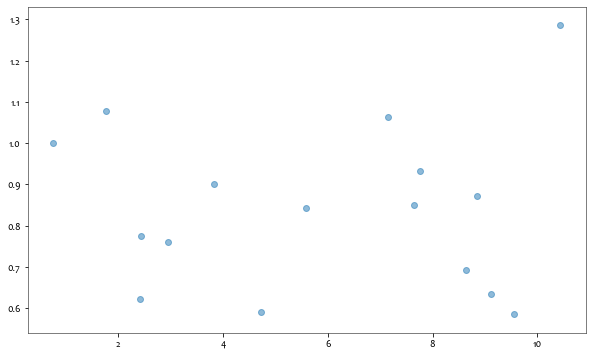

In [52]:
### Acc/Dec ratio
plt.scatter(summary_stats.total_dist_xtrp, summary_stats.acc_dec_ratio, alpha=0.5)
# See https://www.youtube.com/watch?v=teCgjQ2ZKNo 19 mins for typical values
# Label players
# Shouldn't have values over 1?
# This could be where players accelerate in camera shot, but deceleration is out of camera range.  Normalize?


# 5. Acceleration/Deceleration profiles

In [ ]:
# TBD

# 6. Sequences of peak intensity

In [ ]:
# TBD

# 7. Metabolic power

In [ ]:
# TBD